In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('/home/helfrech/Tools/GCH/GCH')

# Maths
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Plotting
import matplotlib.pyplot as plt

# Atoms
from ase.io import read, write

# ML
from regression import KPCovR, PCovR
from decomposition import PCA
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast
from gch_init import gch_init
from gch_run import gch_run

# Utilities
import h5py
import json
import subprocess
import glob
from copy import deepcopy
import project_utils as utils
from tools import load_json

# SOAP
from soap import quippy_soap, librascal_soap

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
#sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
#from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2
#from utilities.sklearn_covr.pcovr import PCovR as PCovR2

In [4]:
# TODO: consolidate into functions so can do both PCA and (K)PCovR 
# without commenting out stuff or chunks of repeated code

# Model setup

In [5]:
cutoff = 6.0
centers = [14] # Center on Si, take Si and O in environment

In [7]:
# Load IZA cantons to remove RWY
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0]
#cantons_iza = np.delete(cantons_iza, RWY)

In [8]:
# Get indicies of high-error DEEM 330k structures for removal
idxs_330k_delete = np.loadtxt('../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [9]:
# TODO: change this to do all Deem and IZA using the computed cell differences,
# or just get an estimate
# Compute cell uncertainty (use CIFs b/c we have the original, unoptimized structures)
orig_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Orig_cif_files.d/*.cif'))
opt_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Opt_cif_files.d/*.cif'))

# All the IZA structures are in alphabetical order, so this should work
orig_glob.pop(RWY)
opt_glob.pop(RWY)

# Compute cell errors -- not a robust method, but should give
# some sort of number to the fractional uncertainty in the cell vectors
cell_errors = []
for orig, opt in zip(orig_glob, opt_glob):
    orig_cif = aseio.read(orig)
    opt_cif = aseio.read(opt)
    cell_errors.append(np.linalg.norm(orig_cif.cell - opt_cif.cell)**2 / np.linalg.norm(orig_cif.cell)**2)
    
cell_errors = np.asarray(cell_errors)
cell_rmse = np.sqrt(np.mean(cell_errors))

print(cell_rmse)

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(74, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(229, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(63, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMEN

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(20, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(58, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(127, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(10, setting=1). This may result in wrong setting!
  setting_name, spacegro

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(81, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(138, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(66, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


0.012027966940699788


In [10]:
# Load idxs_deem_train and idxs_iza_train
idxs_deem_train = np.loadtxt('../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_iza_train = np.loadtxt('../Processed_Data/IZA_226/train.idxs', dtype=int)

# Functions

In [ ]:
# Concatenate IZA and DEEM properties, remove structures
def concatenate_data(dataset_files, idxs_delete, output=None, center=False,
                     **load_params, **save_params):
    datasets = []
    for (dataset_file, idx_delete) in zip(dataset_files, idxs_delete):
        if dataset_file.endswith('.hdf5'):
            data = utils.load_hdf5(dataset_file, **load_params)
            write_fn = utils.save_hdf5
        elif dataset_file.endswith('.xyz'):
            data = read(dataset_file, **load_params)
            write_fn = write
        else:
            data = np.loadtxt(dataset_file, **load_params)
            write_fn = np.savetxt
        
        if isinstance(data, np.ndarray):
            data = np.delete(data, idx_delete)
        else:
            for idx in np.sort(idx_delete)[0::-1]:
                del data[idx] 
            
        # TODO: centering
            
        datasets.extend(data)
        
    if output is not None:
        write_fn(output, datasets, **save_params)
    else:
        return datasets
        
# Compute and save hull distances
def hull_distances(vprobprune, energies, projections, n_dim):
    gch_vertices = np.nonzero(vprobprune[-1])[0]
    
    vertices = np.zeros(projections.shape[0], dtype=int)
    vertices[gch_vertices] = 1
    
    energies_gch = energies[gch_vertices]
    projections_gch = projections[gch_vertices]
    
    ep = np.hstack((energies[:, np.newaxis], projections))
    ep_gch = np.hstack((energies_gch[:, np.newaxis], projections_gch))
    
    vertex_hull = ConvexHull(ep_gch[:, 0:n_dim])
    
    # Omit the simplices on the 'top' of the GCH
    vertex_hull_facets = np.delete(
        vertex_hull.equations,
        np.nonzero(vertex_hull.equations[:, 0] > 0.0),
        axis=0
    )
    
    hull_distance = -1.0 * (
        np.matmul(ep[:, 0:n_dim], vertex_hull_facets[:, 0:-1].T) 
        + vertex_hull_facets[:, -1]
    )
    
    hull_distance_energy = -1.0 * d / vertex_hull_facets[:, 0]
    
    hull_distance = np.amin(np.abs(d), axis=1)
    hull_distance_energy = np.amin(np.abs(de), axis=1)
    
    return hull_distance, hull_distance_energy

# Build a GCH based on PCovR projections

In [10]:
#Load centering and scale factors to apply to the rattled structures
center_scale = load_json(f'../Processed_Data/Models/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/center_scale.json', array_convert=True)

In [11]:
gch_dir = f'../Processed_Data/Models/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH'

if not os.path.exists(gch_dir):
    os.makedirs(gch_dir)

In [12]:
print(idxs_330k_delete[::-1])

[329345 326005 265045  95800  38664]


In [13]:
# Concatenate IZA and DEEM xyz files
# TODO: consolidate the OPT files -- IZA_OPT should just be IZA and DEEM_10000_OPT should be Raw_Data/DEEM_10k/DEEM_10000.xyz
deem = aseio.read('../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', index=':')
for idx in idxs_330k_delete[::-1]:
    deem.pop(idx)
iza = aseio.read('../Raw_Data/GULP/IZA_226/IZA_OPT.xyz', index=':')
iza.pop(RWY[0]) # All the IZA structures are in alphabetical order, so this should work
aseio.write(f'{gch_dir}/iza+deem.xyz', iza + deem, format='extxyz')

atoms_files = ['../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', '../Raw_Data/GULP/IZA_226/IZA_OPT.xyz']
idxs_delete = [idxs_330k_delete, RWY]
concatenate_data(atoms_files, )

# Indices of the DEEM 10k set within the 330k structures
#idxs_deem_10k = np.loadtxt('../Processed_Data/DEEM_330konDEEM_10k/deem_10k.idxs', dtype=int)

# Prepare energies and volumes
volumes_deem = np.loadtxt('../Processed_Data/DEEM_330k/structure_volumes.dat')
volumes_iza = np.delete(np.loadtxt('../Processed_Data/IZA_226/structure_volumes.dat'), RWY)
volumes = np.concatenate((volumes_iza, volumes_deem))

energies_deem = np.loadtxt('../Processed_Data/DEEM_330k/structure_energies.dat')
energies_deem = np.delete(energies_deem, idxs_330k_delete)
#energies_deem_opt = np.loadtxt('../Processed_Data/DEEM_10k/structure_energies_opt.dat')
energies_deem_opt = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=2)
energies_deem_opt = np.delete(energies_deem_opt, idxs_330k_delete)
energies_iza = np.delete(np.loadtxt('../Processed_Data/IZA_226/structure_energies.dat'), RWY)
energies = np.concatenate((energies_iza, energies_deem_opt))
energy_errors = energies_deem - energies_deem_opt

energies -= np.mean(energies, axis=0)
energy_rmse = np.sqrt(np.mean(energy_errors**2))

np.savetxt(f'{gch_dir}/energies_per_si.dat', energies)

print(energy_rmse)

0.08234833243140663


In [14]:
# Load projections to convert HDF5 to text so the GCH utility can load it;
# use all 330k DEEM structures
deem_file = f'../Processed_Data/DEEM_330k/Data/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structures.hdf5'
T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)
T_deem = np.delete(T_deem, idxs_330k_delete, axis=0)

iza_file = f'../Processed_Data/IZA_226/Data/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr_structures.hdf5'
T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

np.savetxt(f'{gch_dir}/T.dat', np.vstack((T_iza, T_deem)))

In [15]:
# Unpickle the reference PCovR model
# Also load it's x and y normalizers
pcovr_file = f'../Processed_Data/Models/{cutoff}/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/pcovr.json'
pcovr_model_dict = load_json(pcovr_file, array_convert=True)
pcovr = PCovR()
pcovr.__dict__ = pcovr_model_dict

In [16]:
# Initialize GCH
# TODO: set these as global parameters, except gch_dir is different for PCovR and PCA
pk = f'{gch_dir}/T.dat' # File containing the kernel (or projections)
pnrg = f'{gch_dir}/energies_per_si.dat' # File containing the energies
setxyz = f'{gch_dir}/iza+deem.xyz' # File containing the structures
wdir_local = f'{gch_dir}/rattled' # Directory in which to save the rattled reference structures
s_c = cell_rmse # Uncertainty in cell between structures # TODO: this probably shouldn't be the cell rmse
s_e = energy_rmse # Uncertainty in energy
ndim = 3 # GCH dimensions (includes energy)
numref = 100 # Number of reference structures
numshaken = 10 # Number of rattled structures per reference
conv = 0.20 # Convergence threshold: 100/conv hulls are constructed
mode = 'fps' # Selection mode for the reference structures
npca = None # Number of KPCA components: None for providing projections, <= 0 for taking all components

gch_init(pk, pnrg, setxyz, wdir_local, s_c, s_e, ndim, numref, numshaken, conv, mode, npca)

Loading the kernel matrix, it can take a minute if thousands of elements
/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH/rattled
DONE: Loaded data
Initializing statistical sampling of the fuzzy GCH
Uncertainty in Cartesian positions 0.028715444783023805
DONE ! go to /scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH/rattled/ to see what's in there


In [17]:
# Compute SOAPs for shaken structures
shaken_refs = aseio.read(f'{gch_dir}/rattled/shaketraj.xyz', index=':')

shaken_ref_soaps = librascal_soap(shaken_refs, centers, **soap_hyperparameters, 
                                  normalize=False, average=True, concatenate=True)
shaken_ref_soaps = (shaken_ref_soaps - center_scale['center']) / center_scale['scale']

100%|██████████| 1100/1100 [00:14<00:00, 77.79it/s]


In [18]:
# We initialize the GCH on all structures, but project the
# rattled structures using the same train set as was used to build
# the original PCovR model
T_rattled = pcovr.transform(shaken_ref_soaps)
np.savetxt(f'{gch_dir}/rattled/T.dat', T_rattled)

In [19]:
T = np.loadtxt(f'{gch_dir}/T.dat')
ref_idxs = np.loadtxt(f'{gch_dir}/rattled/refstruct.idx', dtype=int)

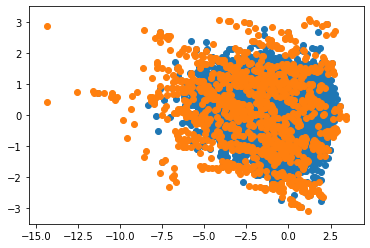

In [20]:
plt.scatter(T[:, 0], T[:, 1])
#plt.scatter(T_tmp[:, 0], T_tmp[:, 1]) ###
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

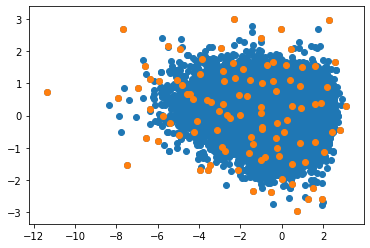

In [21]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T[ref_idxs, 0], T[ref_idxs, 1])
plt.show()

In [ ]:
# Run GCH
shk = f'{gch_dir}/rattled/T.dat' # File containing the kernel (or projections) for the rattled structures
wdir = f'{gch_dir}/rattled' # Directory in which the rattled reference structures reside
mp = 0.99 # Cutoff probability for determining the GCH vertices
gch_run(shk, wdir, mp)

We will load both the dataset kernel and the shaken kernel, it could take some minutes in case of thousands of structures..
You have selected 500 convex hulls samples per pruning iterations
Statistical sampling of the fuzzy GCH
GCH construction :  65.65865087509155  sec
Single Hull construction during before pruning :  66.00353074073792  sec


# Run GCH on the PCA

In [11]:
#Load centering and scale factors to apply to the rattled structures
center_scale = load_json(f'../Processed_Data/Models/{cutoff}/Linear_Models/PCA/center_scale.json', array_convert=True)

In [12]:
gch_dir = f'../Processed_Data/Models/{cutoff}/Linear_Models/PCA/GCH'

if not os.path.exists(gch_dir):
    os.makedirs(gch_dir)

In [13]:
print(idxs_330k_delete[::-1])

[329345 326005 265045  95800  38664]


In [14]:
# Concatenate IZA and DEEM xyz files
# TODO: consolidate the OPT files -- IZA_OPT should just be IZA and DEEM_10000_OPT should be Raw_Data/DEEM_10k/DEEM_10000.xyz
deem = aseio.read('../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', index=':')
for idx in idxs_330k_delete[::-1]:
    deem.pop(idx)
iza = aseio.read('../Raw_Data/GULP/IZA_226/IZA_OPT.xyz', index=':')
iza.pop(RWY) # All the IZA structures are in alphabetical order, so this should work
aseio.write(f'{gch_dir}/iza+deem.xyz', iza + deem, format='extxyz')

# Indices of the DEEM 10k set within the 330k structures
#idxs_deem_10k = np.loadtxt('../Processed_Data/DEEM_330konDEEM_10k/deem_10k.idxs', dtype=int)

# Prepare energies and volumes
volumes_deem = np.loadtxt('../Processed_Data/DEEM_330k/structure_volumes.dat')
volumes_iza = np.delete(np.loadtxt('../Processed_Data/IZA_226/structure_volumes.dat'), RWY)
volumes = np.concatenate((volumes_iza, volumes_deem))

energies_deem = np.loadtxt('../Processed_Data/DEEM_330k/structure_energies.dat')
energies_deem = np.delete(energies_deem, idxs_330k_delete)
#energies_deem_opt = np.loadtxt('../Processed_Data/DEEM_10k/structure_energies_opt.dat')
energies_deem_opt = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=2)
energies_deem_opt = np.delete(energies_deem_opt, idxs_330k_delete)
energies_iza = np.delete(np.loadtxt('../Processed_Data/IZA_226/structure_energies.dat'), RWY)
energies = np.concatenate((energies_iza, energies_deem_opt))
energy_errors = energies_deem - energies_deem_opt

energies -= np.mean(energies, axis=0)
energy_rmse = np.sqrt(np.mean(energy_errors**2))

np.savetxt(f'{gch_dir}/energies_per_si.dat', energies)

print(energy_rmse)

0.08234833243140663


In [15]:
# Load projections to convert HDF5 to text so the GCH utility can load it;
# use all 330k DEEM structures
deem_file = f'../Processed_Data/DEEM_330k/Data/{cutoff}/Linear_Models/PCA/pca_structures.hdf5'
T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)
T_deem = np.delete(T_deem, idxs_330k_delete, axis=0)

iza_file = f'../Processed_Data/IZA_226/Data/{cutoff}/Linear_Models/PCA/pca_structures.hdf5'
T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

np.savetxt(f'{gch_dir}/T.dat', np.vstack((T_iza, T_deem)))

In [16]:
# Unpickle the reference PCA model
pca_file = f'../Processed_Data/Models/{cutoff}/Linear_Models/PCA/pca.json'
pca_model_dict = load_json(pca_file, array_convert=True)
pca = PCA()
pca.__dict__ = pca_model_dict

In [17]:
# Initialize GCH
pk = f'{gch_dir}/T.dat' # File containing the kernel (or projections)
pnrg = f'{gch_dir}/energies_per_si.dat' # File containing the energies
setxyz = f'{gch_dir}/iza+deem.xyz' # File containing the structures
wdir_local = f'{gch_dir}/rattled' # Directory in which to save the rattled reference structures
s_c = cell_rmse # Uncertainty in cell between structures # TODO: this probably shouldn't be the cell rmse
s_e = energy_rmse # Uncertainty in energy
ndim = 3 # GCH dimensions (includes energy)
numref = 100 # Number of reference structures
numshaken = 10 # Number of rattled structures per reference
conv = 0.20 # Convergence threshold: 100/conv hulls are constructed
mode = 'fps' # Selection mode for the reference structures
npca = None # Number of KPCA components: None for providing projections, <= 0 for taking all components

gch_init(pk, pnrg, setxyz, wdir_local, s_c, s_e, ndim, numref, numshaken, conv, mode, npca)

Loading the kernel matrix, it can take a minute if thousands of elements
/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/../Processed_Data/Models/6.0/Linear_Models/PCA/GCH/rattled
DONE: Loaded data
Initializing statistical sampling of the fuzzy GCH
Uncertainty in Cartesian positions 0.029102192144807925
DONE ! go to /scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/../Processed_Data/Models/6.0/Linear_Models/PCA/GCH/rattled/ to see what's in there


In [18]:
# Compute SOAPs for shaken structures
shaken_refs = aseio.read(f'{gch_dir}/rattled/shaketraj.xyz', index=':')

shaken_ref_soaps = librascal_soap(shaken_refs, centers, **soap_hyperparameters, 
                                  normalize=False, average=True, concatenate=True)
shaken_ref_soaps = (shaken_ref_soaps - center_scale['center']) / center_scale['scale']

100%|██████████| 1100/1100 [00:14<00:00, 78.36it/s]


In [19]:
# We initialize the GCH on all structures, but project the
# rattled structures using the same train set as was used to build
# the original PCA model
T_rattled = pca.transform(shaken_ref_soaps)
np.savetxt(f'{gch_dir}/rattled/T.dat', T_rattled)

In [20]:
T = np.loadtxt(f'{gch_dir}/T.dat')
ref_idxs = np.loadtxt(f'{gch_dir}/rattled/refstruct.idx', dtype=int)

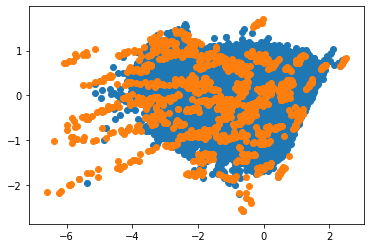

In [21]:
plt.scatter(T[:, 0], T[:, 1])
#plt.scatter(T_tmp[:, 0], T_tmp[:, 1]) ###
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

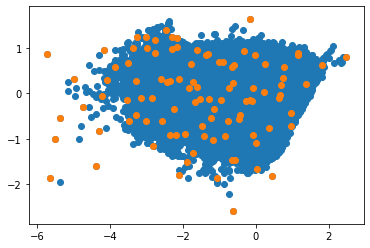

In [22]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T[ref_idxs, 0], T[ref_idxs, 1])
plt.show()

In [ ]:
# Run GCH
shk = f'{gch_dir}/rattled/T.dat' # File containing the kernel (or projections) for the rattled structures
wdir = f'{gch_dir}/rattled' # Directory in which the rattled reference structures reside
mp = 0.99 # Cutoff probability for determining the GCH vertices
gch_run(shk, wdir, mp)

We will load both the dataset kernel and the shaken kernel, it could take some minutes in case of thousands of structures..
You have selected 500 convex hulls samples per pruning iterations
Statistical sampling of the fuzzy GCH
GCH construction :  83.70618772506714  sec
Single Hull construction during before pruning :  83.45036721229553  sec
